In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

读取属性数据

In [2]:
attribute_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,7),nrows=293, names=['marks', 'attribute ID','ignored','title','url'])
attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   marks         293 non-null    object
 1   attribute ID  293 non-null    int64 
 2   ignored       293 non-null    int64 
 3   title         293 non-null    object
 4   url           293 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.6+ KB


没有缺失值

In [3]:
attribute_df.head(10)

,marks,attribute ID,ignored,title,url
0,A,1287,1,International AutoRoute,/autoroute
1,A,1288,1,library,/library
2,A,1289,1,Master Chef Product Information,/masterchef
3,A,1297,1,Central America,/centroam
4,A,1215,1,For Developers Only Info,/developer
5,A,1279,1,Multimedia Golf,/msgolf
6,A,1239,1,Microsoft Consulting,/msconsult
7,A,1282,1,home,/home
8,A,1251,1,Reference Support,/referencesupport
9,A,1121,1,Microsoft Magazine,/magazine


读取用户数据

In [4]:
user_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,301), names=['marks', 'ID','ignored'])
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131365 entries, 0 to 131364
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   marks    131365 non-null  object
 1   ID       131365 non-null  int64 
 2   ignored  131365 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.0+ MB


没有缺失值

In [5]:
user_df.head(10)

,marks,ID,ignored
0,C,10001,10001
1,V,1000,1
2,V,1001,1
3,V,1002,1
4,C,10002,10002
5,V,1001,1
6,V,1003,1
7,C,10003,10003
8,V,1001,1
9,V,1003,1


# 1.  数据预处理

## 1.1 属性数据处理

去除'marks','ignored'两个无用属性，获取id到name的字典映射

In [6]:
attribute_df.drop(['marks','ignored'],axis=1,inplace=True)
id2name = pd.Series(attribute_df['title'].values,index=attribute_df['attribute ID']).to_dict()

In [7]:
attribute_df.head(10)

,attribute ID,title,url
0,1287,International AutoRoute,/autoroute
1,1288,library,/library
2,1289,Master Chef Product Information,/masterchef
3,1297,Central America,/centroam
4,1215,For Developers Only Info,/developer
5,1279,Multimedia Golf,/msgolf
6,1239,Microsoft Consulting,/msconsult
7,1282,home,/home
8,1251,Reference Support,/referencesupport
9,1121,Microsoft Magazine,/magazine


## 1.2 用户数据处理

marks“C”表示新用户，“V”表示投票。

我们想知道每个用户的访问情况，所以将数据结构更改为{user:visit sequence}

In [8]:
user = []
record = []
temp_sequence = None
for index, row in user_df.iterrows():
    if row['marks']=='C':
        if temp_sequence!= None:
            record.append(temp_sequence)
        user.append(row['ID'])
        temp_sequence=[]
    else:
        temp_sequence.append(row['ID'])
record.append(temp_sequence)
user_df = pd.DataFrame({"user":user,"visit":record})
user_df.head(10)

,user,visit
0,10001,"[1000, 1001, 1002]"
1,10002,"[1001, 1003]"
2,10003,"[1001, 1003, 1004]"
3,10004,[1005]
4,10005,[1006]
5,10006,"[1003, 1004]"
6,10007,[1007]
7,10008,[1004]
8,10009,"[1008, 1009]"
9,10010,"[1010, 1000, 1011, 1012, 1013, 1014]"


# 2.  数据探索性分析:

## 2.1 页面访问量分布

In [9]:
record_dict = {}
for index, row in user_df.iterrows():
    sequence=row['visit']
    for i in sequence:
        if i in record_dict.keys():
            record_dict[i]+=1
        else:
            record_dict[i]=1
attr_list = [i for i in record_dict.keys()]
hit_list = [record_dict[i] for i in attr_list]
hit_df = pd.DataFrame({"attribute":attr_list,"visited time":hit_list})
hit_df.sort_values("visited time",inplace=True,ascending=[False])
hit_df["attribute"] = hit_df["attribute"].map(lambda x:int(x))
attribute_df=pd.merge(attribute_df,hit_df,how='left',left_on="attribute ID",right_on="attribute")
attribute_df.drop(columns="attribute",inplace=True)
attribute_df["visited time"] = attribute_df["visited time"].fillna(0)
attribute_df["visited time"].describe()

count      293.000000
mean       336.686007
std       1156.420373
min          0.000000
25%          9.000000
50%         44.000000
75%        183.000000
max      10836.000000
Name: visited time, dtype: float64

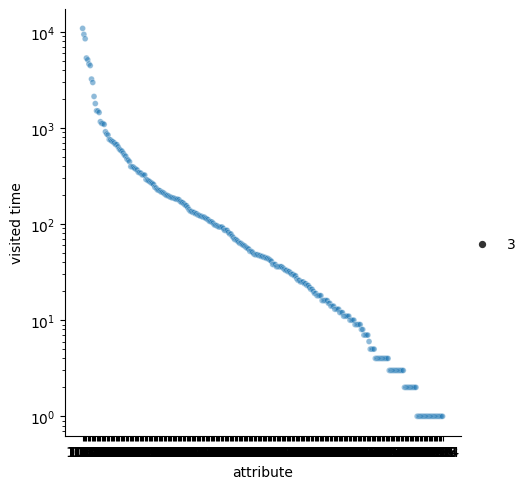

In [10]:
hit_df['attribute']= hit_df['attribute'].map(lambda x:str(x))
sns.relplot(x="attribute",y="visited time",data=hit_df,size=3, alpha=0.5).set(yscale='log')

## 2.2 前十最常被访问的页面

In [11]:
attribute_df.sort_values("visited time",inplace=True,ascending=[False])
attribute_df.head(10)[["title","visited time",'url']]

,title,visited time,url
57,Free Downloads,10836.0,/msdownload
283,Internet Explorer,9383.0,/ie
17,Microsoft.com Search,8463.0,/search
287,isapi,5330.0,/isapi
212,Products,5108.0,/products
157,Windows Family of OSs,4628.0,/windows
78,Support Desktop,4451.0,/support
23,Internet Site Construction for Developers,3220.0,/sitebuilder
30,Knowledge Base,2968.0,/kb
122,Web Site Builder's Gallery,2123.0,/gallery


## 2.3 未被访问的页面

In [12]:
attribute_df.sort_values("visited time",inplace=True)
attribute_df[attribute_df["visited time"]==0]["title"]

0               International AutoRoute
3                       Central America
2       Master Chef Product Information
1                               library
209                     MS North Africa
164                                news
211    Activate the Internet Conference
41                              Encarta
39                            Bookshelf
Name: title, dtype: object

# 3.  关联规则挖掘: 使用Apriori算法根据用户浏览记录计算频繁项集和关联规则。

In [13]:
user_df

,user,visit
0,10001,"[1000, 1001, 1002]"
1,10002,"[1001, 1003]"
2,10003,"[1001, 1003, 1004]"
3,10004,[1005]
4,10005,[1006]
...,...,...
32706,42707,"[1008, 1030, 1009, 1058, 1004, 1018]"
32707,42708,"[1008, 1027, 1123, 1038, 1026, 1041]"
32708,42709,"[1001, 1003]"
32709,42710,"[1035, 1001, 1018]"


Apriori算法的核心思想是基于频繁项集理论的递归方法，采用逐层搜索的迭代方法挖掘出在目标事务数据库中所有频繁项集，直至找到最高阶频繁项集即止，最后通过对获得的频繁项集进行计算得到强关联规则。

In [14]:
data=list(user_df['visit'])
data

[[1000, 1001, 1002],
 [1001, 1003],
 [1001, 1003, 1004],
 [1005],
 [1006],
 [1003, 1004],
 [1007],
 [1004],
 [1008, 1009],
 [1010, 1000, 1011, 1012, 1013, 1014],
 [1015, 1016, 1017, 1018, 1019],
 [1020, 1021],
 [1022],
 [1023],
 [1024],
 [1025, 1026],
 [1027, 1017, 1026, 1028],
 [1004],
 [1017, 1004, 1018, 1029, 1008, 1030, 1031, 1032, 1003, 1033, 1002],
 [1008, 1001, 1034, 1002],
 [1017,
  1004,
  1018,
  1035,
  1036,
  1008,
  1037,
  1009,
  1038,
  1026,
  1039,
  1040,
  1032,
  1041,
  1042,
  1034,
  1043],
 [1008, 1017, 1004],
 [1008],
 [1044],
 [1045],
 [1034],
 [1008, 1046, 1034],
 [1295],
 [1034],
 [1017, 1048],
 [1045,
  1049,
  1018,
  1008,
  1035,
  1027,
  1046,
  1009,
  1031,
  1041,
  1001,
  1003,
  1002,
  1034],
 [1050],
 [1032],
 [1037, 1009, 1004],
 [1008, 1051, 1038, 1031, 1052, 1053, 1018],
 [1051,
  1054,
  1018,
  1035,
  1008,
  1009,
  1026,
  1040,
  1052,
  1041,
  1003,
  1034,
  1048],
 [1008, 1055, 1056, 1017, 1032],
 [1008, 1027, 1026, 1041, 1032, 1

In [15]:
from mlxtend.preprocessing import TransactionEncoder

d=TransactionEncoder()
d_data=d.fit(data).transform(data)
df=pd.DataFrame(d_data,columns=d.columns_)
df


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1276,1277,1278,1279,1280,1281,1282,1283,1284,1295
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32706,False,False,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
32707,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
32708,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32709,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

选择最小支持度为10%，得到七组频繁项集

In [17]:
itemsets = apriori(df, min_support=0.1, use_colnames=True)
itemsets

,support,itemsets
0,0.136070,(1001)
1,0.258720,(1004)
2,0.331265,(1008)
3,0.141481,(1009)
4,0.156155,(1017)
5,0.162942,(1018)
6,0.286845,(1034)
7,0.160802,"(1008, 1034)"


计算关联规则

In [18]:
association_rules(itemsets, metric='lift', min_threshold=1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(1008),(1034),0.331265,0.286845,0.160802,0.485419,1.692267,0.06578,1.385894,0.611717
1,(1034),(1008),0.286845,0.331265,0.160802,0.560588,1.692267,0.06578,1.521888,0.573616


# 4.  结果评估: 

计算关联规则的支持度、置信度和提升度，得出强关联规则。


由上表结果可以看出强关联规则为{1008 -> 1034}与{1034 -> 1008}

前者的支持度、置信度和提升度分别为0.160802	0.485419	1.692267
后者的支持度、置信度和提升度分别为0.160802	0.560588	1.692267

# 5.  结果分析与应用: 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

根据得到的强关联规则，建议在1008和1034代表的网站建立两个站点互相的导航，使用户能够方便快捷的跳转网站。